# Determine Splits
Figure out what variable to use to split molecules between "small" and "larger"

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from scipy.interpolate import interp1d
from ase.io.xyz import read_xyz
from io import StringIO
from math import ceil
import pickle as pkl
import numpy as np
import shutil
import os

In [2]:
schnet_dir = os.path.join('..', 'benchmark', 'schnet-v2')

## Get the Datasets
Load in the training and test splits

In [3]:
train_data, test_data = load_benchmark_data()

## Evaluate the Size of Molecules
Make a few different measures of the size of the molecule:
- `n_atom`: Total number of atoms
- `n_heavy`: Total number of heavy atoms
- `n_electron`: Total number of electrons (counting valence and core)

In [4]:
def get_counts(xyz):
    """Given the XYZ coordinates of a molecule, compute its size
    
    Args:
        xyz (string): XYZ-format file of the atomic structure
    Returns:
        n_heavy_atom (int): Number of heavy (i.e., non-Hydrogen) atoms
        n_electrons (int): Number of electrons in the system
        elements ({string}): Elements in this compound
    """
    
    mol = read_xyz(StringIO(xyz)).__next__()
    Z = mol.get_atomic_numbers()
    return (Z > 1).sum(), Z.sum(), set(mol.get_chemical_symbols())

In [5]:
get_counts(train_data['xyz'].iloc[0])

(1, 10, {'C', 'H'})

In [6]:
%%time
train_data['n_heavy'], train_data['n_electron'], train_data['elements'] = zip(*train_data['xyz'].apply(get_counts))

CPU times: user 29.3 s, sys: 419 ms, total: 29.7 s
Wall time: 29.7 s


## What is the Range of Molecular Sizes?
One main test we want to set up is to assess whether a model trained on smaller molecules can be used to predict the properties of larger molecules

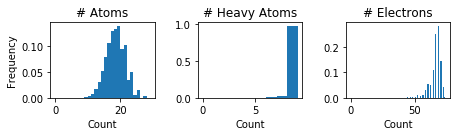

In [7]:
fig, axs = plt.subplots(1, 3)

for ax, tag, label in zip(axs, ['n_atom', 'n_heavy', 'n_electron'],
                          ['# Atoms', '# Heavy Atoms', '# Electrons']):
    
    ax.hist(train_data[tag], bins=np.arange(0, train_data[tag].max() + 1), density=True)
    ax.set_title(label)
    ax.set_xlabel('Count')
axs[0].set_ylabel('Frequency')
    
fig.set_size_inches(6.5, 2)
fig.tight_layout()

*Finding*: Of these, the electron counts and number of atoms would be better for making test splits as they are closer to normally-distributed. Number of electrons correlates to execution time, so let's use that for splits

## Make Training Set Subsets
Make subsets of the training data that are similar in size to our dataset

Delete the current training subsets

In [8]:
if os.path.isdir('subsets'):
    shutil.rmtree('subsets')
os.mkdir('subsets')

Load in the current training DB

In [9]:
with open(os.path.join(schnet_dir, 'train_dataset.pkl'), 'rb') as fp:
    train_db = pkl.load(fp)
    train_db.dbpath = os.path.join(schnet_dir, train_db.dbpath)

/home/loganw/.conda/envs/jcesr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
e_count = list(range(train_data['n_electron'].min(),
                    train_data['n_electron'].max() + 1))
train_sizes = [(train_data['n_electron'] < i).sum() for i in e_count]

In [11]:
t_int = interp1d(train_sizes, e_count)
for s in [120, 1000, 10000, 100000]:
    
    # Get the target size
    target_e = int(ceil(t_int(s)))
    actual_s = (train_data['n_electron'] < target_e).sum()
    print('Target: {} - e Count: {} - Actual: {:.0f}'.format(s, target_e, actual_s))
    
    # Get the entries for the training set
    inds = np.where((train_data['n_electron'] < target_e))[0]
    
    # Make and save the subset db
    subset_sb = train_db.create_subset(inds)
    with open(os.path.join('subsets', '{}.pkl'.format(target_e)), 'wb') as fp:
        pkl.dump(subset_sb, fp)

Target: 120 - e Count: 41 - Actual: 152
Target: 1000 - e Count: 51 - Actual: 1161
Target: 10000 - e Count: 61 - Actual: 14317
Target: 100000 - e Count: 71 - Actual: 111906
